# Semantic Segmentation PSPNet

##Setup & import

In [1]:
# Переменные
pathName      = "/content/drive/My Drive/" 
pathNameData  = pathName + "Datasets/" 
pathNameTrain = pathName + "DataTrain/"
prefix        = f'2021_12_'

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

import tensorflow as tf
from keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate,Reshape, Input, Conv2DTranspose, Lambda, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, MaxPooling1D, MaxPooling2D, Activation, GlobalMaxPooling1D, UpSampling1D 
from tensorflow.keras import backend as K 
from tensorflow.keras import utils  

from tensorflow.keras.optimizers import Adam 
from keras.losses import MAE
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image 

from sklearn.model_selection import train_test_split

import random as random 
from PIL import Image 
import time

import pickle
import glob, os

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback


In [4]:
img_width = 176 
img_height =  320 
directory = pathNameData + 'Airplanes/' 
num_classes = 2 # Airpalne & Background

## Data Load



In [ ]:
%%time
images_airplane = [] 
for filename in sorted(os.listdir(directory + 'Air')): 
    images_airplane.append(image.load_img(os.path.join(directory + 'Air',filename),
                                       target_size=(img_width, img_height))) 
print("Train Data (Features) Loaded")

Train Data (Features) Loaded
CPU times: user 28.3 s, sys: 547 ms, total: 28.9 s
Wall time: 52.6 s


In [ ]:
len(images_airplane)

1000

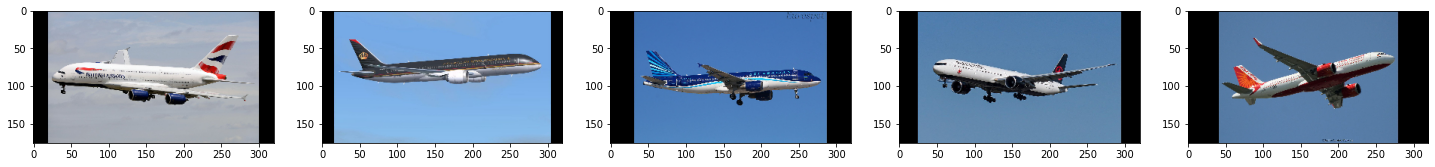

In [ ]:
n = 5 # number images in row
fig, axs = plt.subplots(1, n, figsize=(25, 5)) 
for i in range(n): 
  img = random.choice(images_airplane) 
  axs[i].imshow(img) 
plt.show() 

In [ ]:
segments_airplane = [] 

cur_time = time.time() 
for filename in tqdm(sorted(os.listdir(directory + 'Segment'))):  
    segments_airplane.append(image.load_img(os.path.join(directory + 'Segment',filename),
                                       target_size=(img_width, img_height)))  
print ('Train Data (Target) Loaded. Total time: ', f'{time.time() - cur_time:0.2f}', 'c', sep='') 

  0%|          | 0/1000 [00:00<?, ?it/s]

Train Data (Target) Loaded. Total time: 46.10c


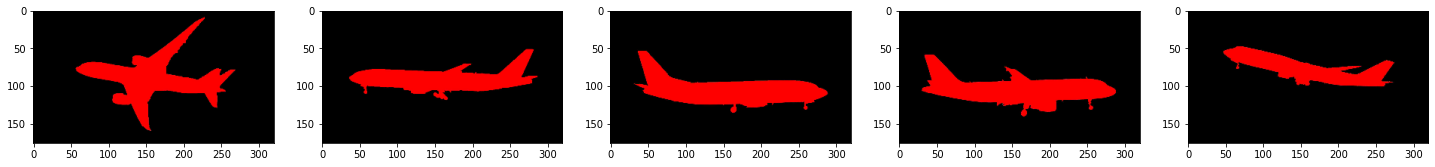

In [ ]:
n = 5 
fig, axs = plt.subplots(1, n, figsize=(25, 5)) 
for i in range(n): 
  img = random.choice(segments_airplane) 
  axs[i].imshow(img) 
plt.show() 

## Data Prepare

In [ ]:
def color2index(color):
    index=0
    if (color[0] + color[1] + color[2]) > 20  : index = 1 # самолет    
    return index  

In [ ]:
def index2color(index2):
    index = np.argmax(index2)
    color=[]
    if index == 0:
        color = [0, 0, 0]  # background
    elif index == 1:
        color = [255, 0, 0]  # airplane
    return color 

In [ ]:
# Index to categorical
def rgbToohe(y, num_classes): 
  y2 = y.copy() 
  y = y.reshape(y.shape[0] * y.shape[1], 3) 
  yt = [] 
  for i in range(len(y)): 
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) 
  yt = np.array(yt) 
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) 
  return yt 

In [ ]:
# Prepare yTrain
def yt_prep(data, num_classes):
  yTrain = [] 
  for seg in tqdm(data): 
    y = image.img_to_array(seg) 
    y = rgbToohe(y, num_classes) 
    yTrain.append(y) 
    if len(yTrain) % 100 == 0: 
      print(len(yTrain)) 
  return np.array(yTrain) 

In [ ]:
%%time
xTrain = [] 
for img in tqdm(images_airplane): 
    x = image.img_to_array(img) 
    xTrain.append(x) 
xTrain = np.array(xTrain) 
print(xTrain.shape) 

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 176, 320, 3)
CPU times: user 422 ms, sys: 580 ms, total: 1 s
Wall time: 1.03 s


In [ ]:
%%time
yTrain = yt_prep(segments_airplane, num_classes) 


  0%|          | 0/1000 [00:00<?, ?it/s]

100
200
300
400
500
600
700
800
900
1000
CPU times: user 13min 31s, sys: 38.8 s, total: 14min 10s
Wall time: 14min 25s


### Save Data

In [ ]:
%%time
# Save DataTrain
np.save(pathNameTrain + prefix + 'xTrain.npy', xTrain, allow_pickle=True, fix_imports=True)
np.save(pathNameTrain + prefix + 'yTrain.npy', yTrain, allow_pickle=True, fix_imports=True)

CPU times: user 153 ms, sys: 786 ms, total: 939 ms
Wall time: 12.4 s


### Restore Data

In [5]:
%%time
# Restore DataTrain
xTrain = np.load (pathNameTrain + prefix + 'xTrain.npy', allow_pickle=True, fix_imports=True)
yTrain = np.load (pathNameTrain + prefix + 'yTrain.npy', allow_pickle=True, fix_imports=True)

CPU times: user 40.6 ms, sys: 818 ms, total: 858 ms
Wall time: 10.3 s


### train_test_split

In [8]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.1)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((900, 176, 320, 3),
 (100, 176, 320, 3),
 (900, 176, 320, 2),
 (100, 176, 320, 2))

## Utils

### color <-> index

In [9]:
n_classes =2
def color2index(color):
    class_=0 # default background

    
    # if pixel color == red (0 channel of  image)
    if (color[0] + color[1] + color[2]) > 20: # tf.image
    #if (color[0] + color[1] + color[2]) > 0.0009:  # sciimage
      class_ = 1 # Change class
      
    return class_ 

def index2color(index2):
    index = np.argmax(index2)
    color=[]
    if index == 0:
        color = [0, 0, 0]  # background
    elif index == 1:
        color = [255, 0, 0]  # airplane
    return color 

### plot_gen_images

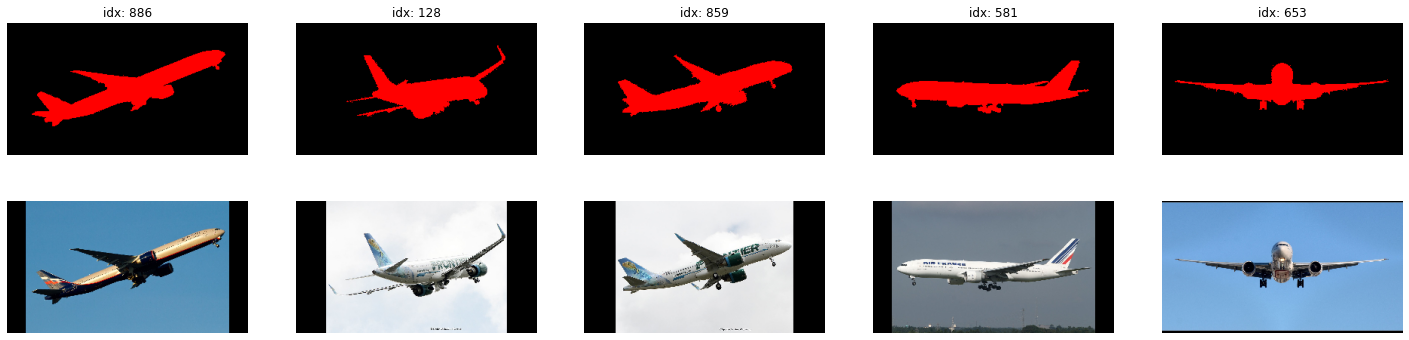

In [21]:
def add_mask(img, seg):
  segment = seg.copy().convert('RGBA')
  mask = np.array(segment)
  mask[mask[:,:,0] <= 10] = [0, 0, 0, 0]
  mask[mask[:,:,0] > 10] = [0, 150, 0, 200]
  img2 = Image.fromarray(img.astype('uint8'))
  img_new = Image.fromarray(mask).convert('RGBA')
  img2.paste(img_new, (0, 0),img_new)
  
  return img2

def plot_gen_images(model=None):  
  if model==None:
    r, c = 2, 5 #  (r - num_rows, c - num_cols)
    fig, axs = plt.subplots(r, c, figsize=(25,6)) 
  else:
    r, c = 3, 5 #  (r - num_rows, c - num_cols)
    fig, axs = plt.subplots(r, c, figsize=(25,10)) 
  idx = np.random.randint(0, len(y_train), c) 
  xt  = x_train[idx]
  yt  = y_train[idx]
  if model:
    fig.suptitle("1. Ground True Segmentation (Mask) , 2. Original Image, 3. Predicted Mask ")
    pred_imgs = model.predict(xt) 
    #pred_imgs = 0.5 * pred_imgs + 0.5 
  for i in range(c):
    axs[0,i].set_title(f"idx: {idx[i]}")
    pr = yt[i].reshape(-1, n_classes) 
    pr1 = []
    for k in range(len(pr)): 
      pr1.append(index2color(pr[k])) 
    pr1 = np.array(pr1) 
    #print(pr1.shape)
    pr1 = pr1.reshape((176,320,3)) 
    img = Image.fromarray(pr1.astype('uint8')) 
    #axs[0,i].imshow(yt[i])
    axs[0,i].imshow(img.convert('RGBA'))
    axs[0,i].axis('off') 

    axs[1,i].imshow(xt[i]/255)
    axs[1,i].axis('off') 
  
    if model:
      pr = pred_imgs[i].reshape(-1, n_classes) 
      pr1 = []
      for k in range(len(pr)): 
        pr1.append(index2color(pr[k])) 
      pr1 = np.array(pr1) 
      pr1 = pr1.reshape(x_val[0].shape) 
      img = Image.fromarray(pr1.astype('uint8')) 
      axs[2,i].imshow(img.convert('RGBA')) 
      axs[2,i].axis('off') 
    
  plt.show()  
plot_gen_images()  

### plot_original_predicted_images_masks

In [38]:
#from IPython.display import display
def add_mask2(img, seg): # -> PIL.Image
  # img, seg: np.arrays
  segment = Image.fromarray(seg.astype('uint8')).convert('RGBA')
  mask = np.array(segment)
  
  mask[mask[:,:,0] <= 20] = [0, 0, 0, 0]
  mask[mask[:,:,0] > 20] = [0, 150, 0, 200]
  
  img2 = Image.fromarray(img.astype('uint8'))
  img_new = Image.fromarray(mask).convert('RGBA')
  img2.paste(img_new, (0, 0),img_new)
  
  return img2
def collect_mask (mask_nparray, n_classes=2, img_shape=(176,320,3)):
  pr = mask_nparray.reshape(-1, n_classes) 
  pr1 = []
  for k in range(len(pr)): 
    pr1.append(index2color(pr[k])) 
  pr1 = np.array(pr1) 
  pr1 = pr1.reshape(img_shape) 
  return pr1
def mask_nparray2img(mask_nparray, n_classes=2, img_shape=(176,320,3)):
  pr1 = collect_mask (mask_nparray, n_classes=n_classes, img_shape=img_shape)
  #print(pr1.shape)
  
  img_mask = Image.fromarray(pr1.astype('uint8')).convert('RGBA')
  return img_mask

def plot_original_predicted_images_masks(indexes, model=None, n_cols=5):
  if model is not None:
    fig, axs = plt.subplots(5, n_cols, figsize=(25, 12)) 
    fig.suptitle("1. Original Image, 2. Ground True Segmentation (GT Mask), 3. Image+GT Mask, 4. Predicted Mask, 5. Image+Predicted Mask")
  else:
    fig, axs = plt.subplots(3, n_cols, figsize=(25, 8)) 
    fig.suptitle("1. Original Image, 2. Ground True Segmentation (GT Mask), 3. Image+GT Mask")
  for i,idx in enumerate(indexes): 
    axs[0,i].set_aspect('auto')
    axs[0,i].imshow(Image.fromarray(x_val[idx].astype('uint8')), ) 
    axs[0,i].axis('off')
    #display(Image.fromarray(x_val[idx].astype('uint8')), width=400, height=300)
    
    axs[1,i].imshow(mask_nparray2img(y_val[idx])) 
    axs[1,i].axis('off')

    axs[2,i].imshow(add_mask2(x_val[idx], collect_mask (y_val[idx])))
    axs[2,i].axis('off')

    if model is not None:
      predict = np.array(model.predict(x_val[idx].reshape(1, img_width, img_height, 3))) 
      pr = predict[0] 
      
      axs[3,i].imshow(mask_nparray2img(y_val[idx])) 
      axs[3,i].axis('off')

      axs[4,i].imshow(add_mask2(x_val[idx], collect_mask (pr)))
      axs[4,i].axis('off')

  plt.show() 

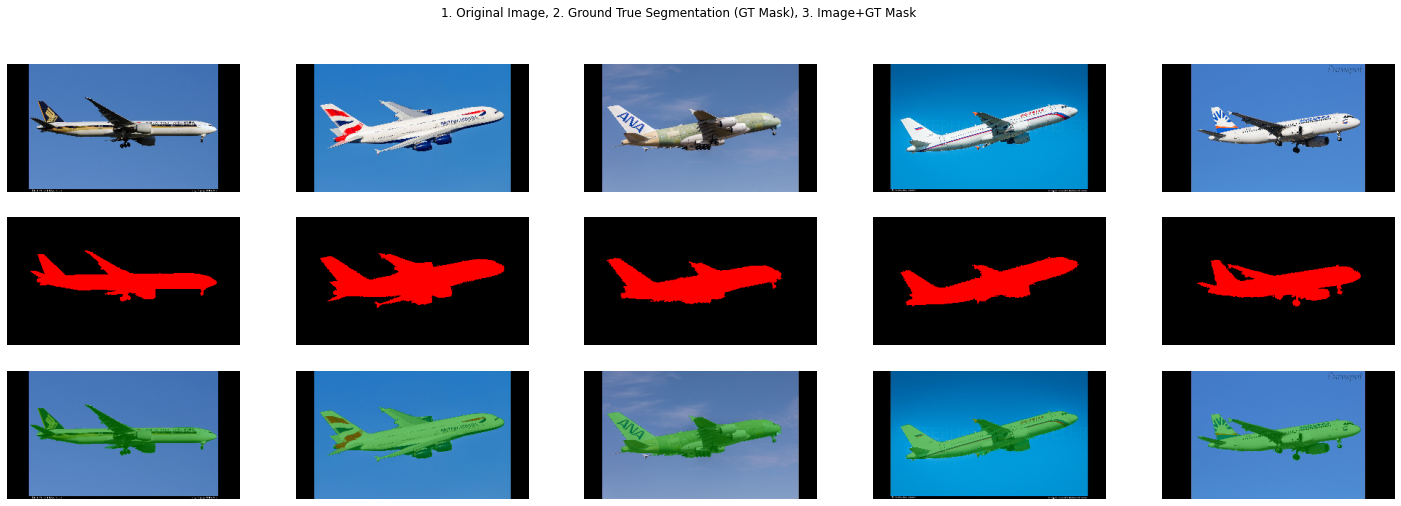

In [28]:
indexes = np.random.randint(0, len(x_val), 5) 
plot_original_predicted_images_masks(indexes)

## PSPNet
Pyramid Scene Parsing Network(PSPNet)

### Create Model

In [15]:
#  Custom metric

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [16]:
def pspnet(num_classes = 3, input_shape= (176, 320, 3)):
    img_input = Input(input_shape)                                         
    # Создаем входной слой с размерностью input_shape

    x = Conv2D(32, (3, 3), padding='same', name='block_conv1')(img_input)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same', name='block_conv2')(x)
    
    # pooling пирамида
    block_1_out = MaxPooling2D((2,2))(x)
    block_2_out = MaxPooling2D((4,4))(x)
    block_3_out = MaxPooling2D((8,8))(x)
    block_4_out = MaxPooling2D((16,16))(x)
    
    # Сверточные слои
    block_1_out=Conv2D(64,(3,3),padding='same',name='block1_conv1')(block_1_out)
    block_1_out = Activation('relu')(block_1_out)
    block_2_out=Conv2D(64,(3,3),padding='same',name='block2_conv1')(block_2_out)
    block_2_out = Activation('relu')(block_2_out)
    block_3_out=Conv2D(64,(3,3),padding='same',name='block3_conv1')(block_3_out)
    block_3_out = Activation('relu')(block_3_out)
    block_4_out=Conv2D(64,(3,3),padding='same',name='block4_conv1')(block_4_out)
    block_4_out = Activation('relu')(block_4_out)
    
    # Увеличиваем размерность
    block_1_out=Conv2DTranspose(32,(3,3),strides=(2,2), padding='same')(block_1_out)
    block_1_out = Activation('relu')(block_1_out)
    block_2_out=Conv2DTranspose(32,(3,3),strides=(4,4), padding='same')(block_2_out)
    block_2_out = Activation('relu')(block_2_out)
    block_3_out=Conv2DTranspose(32,(3,3),strides=(8,8), padding='same')(block_3_out)
    block_3_out = Activation('relu')(block_3_out)
    block_4_out=Conv2DTranspose(32,(3,3),strides=(16,16), padding='same')(block_4_out)
    block_4_out = Activation('relu')(block_4_out)
           
    #объединяем слои
    out = concatenate([block_1_out, block_2_out, block_3_out,block_4_out])
    # Выходной слой
    out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(out)
    # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, out) # Создаем модель с входом 'img_input' и выходом 'out'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  #loss='binary_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [17]:
import tensorflow as tf
#checkpoint_filepath = '/tmp/checkpoint'
checkpoint_filepath = pathNameTrain + prefix + 'checkpoint_mAir'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True)

In [18]:
modelAir = pspnet(2, (img_width, img_height,3))
modelAir.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 block_conv1 (Conv2D)           (None, 176, 320, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 176, 320, 32  0           ['block_conv1[0][0]']            
                                )                                                             

### Train Model

In [ ]:
history = modelAir.fit(x_train, y_train, epochs=10, batch_size=16, 
                       callbacks=[model_checkpoint_callback, TqdmCallback()],
                       validation_data = (x_val, y_val)) 

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
57/57 [==============================] - 32s 353ms/step - loss: 0.6164 - dice_coef: 0.8465 - val_loss: 0.1365 - val_dice_coef: 0.9266
Epoch 2/10
57/57 [==============================] - 18s 318ms/step - loss: 0.1201 - dice_coef: 0.9353 - val_loss: 0.1023 - val_dice_coef: 0.9354
Epoch 3/10
57/57 [==============================] - 18s 311ms/step - loss: 0.1082 - dice_coef: 0.9397 - val_loss: 0.0952 - val_dice_coef: 0.9435
Epoch 4/10
57/57 [==============================] - 18s 319ms/step - loss: 0.0987 - dice_coef: 0.9447 - val_loss: 0.0945 - val_dice_coef: 0.9453
Epoch 5/10
57/57 [==============================] - 18s 311ms/step - loss: 0.0926 - dice_coef: 0.9475 - val_loss: 0.0923 - val_dice_coef: 0.9461
Epoch 6/10
57/57 [==============================] - 18s 308ms/step - loss: 0.0931 - dice_coef: 0.9482 - val_loss: 0.0953 - val_dice_coef: 0.9505
Epoch 7/10
57/57 [==============================] - 18s 317ms/step - loss: 0.0898 - dice_coef: 0.9504 - val_loss: 0.0821 - val_dic

In [ ]:
modelAir.save_weights(pathNameTrain + prefix + 'modelAir_PSPNnet_10e_ohe.h5')

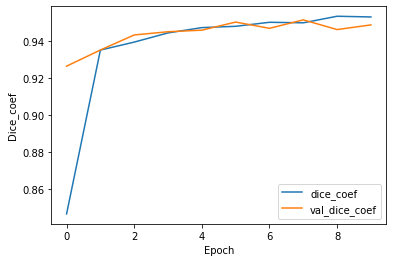

In [ ]:
plt.plot(history.history['dice_coef'], label='dice_coef')
plt.plot(history.history['val_dice_coef'], label = 'val_dice_coef')
plt.xlabel('Epoch')
plt.ylabel('Dice_coef')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

### Prediction



In [19]:
#modelAir.load_weights(pathNameTrain + prefix + 'modelAir_PSPNnet_10e_ohe.h5')
modelAir.load_weights(checkpoint_filepath)

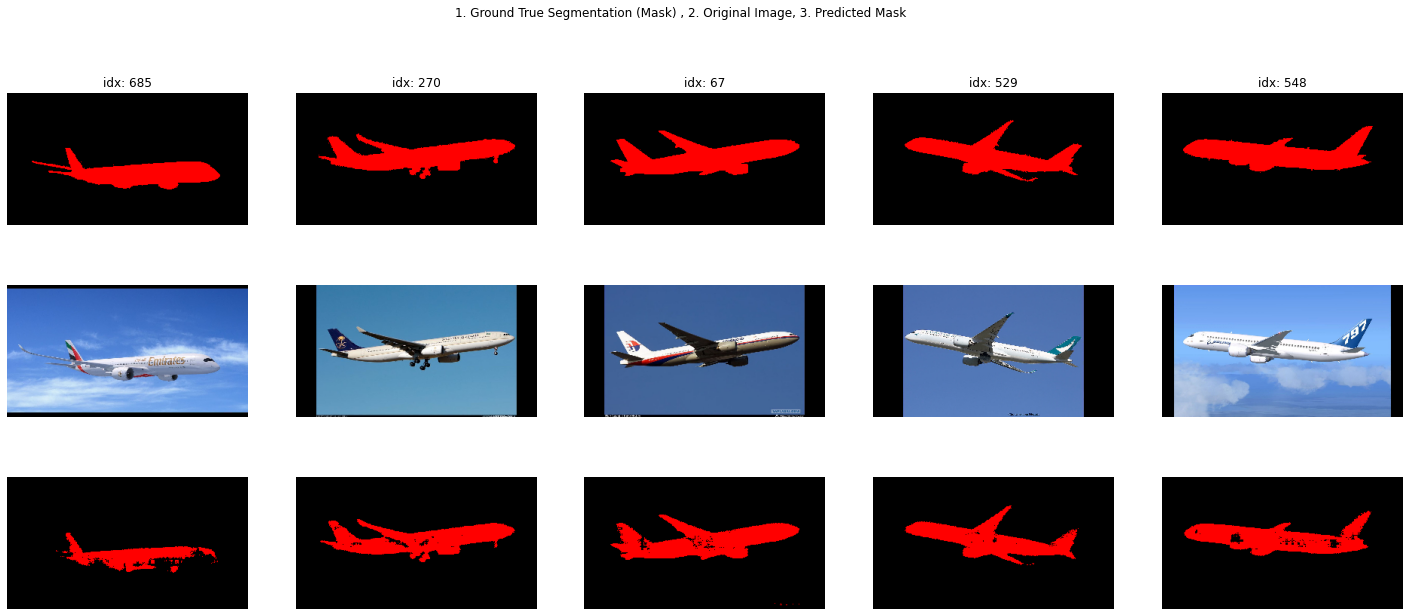

In [22]:
plot_gen_images(modelAir) 

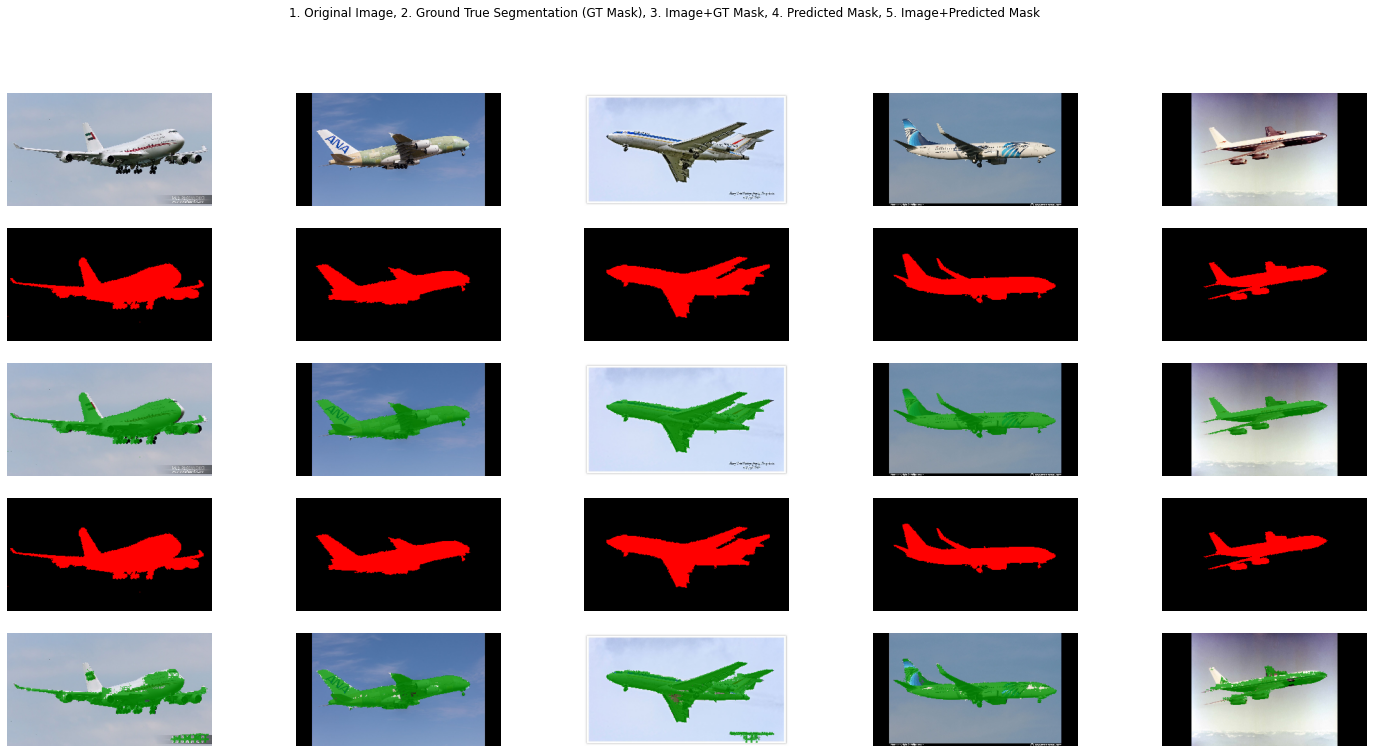

In [39]:
n_cols = 5
n_classes = 2
indexes = np.random.randint(0, len(x_val), n_cols) 
plot_original_predicted_images_masks(indexes, modelAir, n_cols)

## UNet

### Create Model

In [40]:
img_width = 176 
img_height =  320 
#directory = pathNameData + 'Airplanes/' 
num_classes = 2 # Airpalne & Background
img_shape = (176, 320,3)

In [41]:

img     = Input(shape=img_shape)
print(img.shape)
down    = Conv2D(32, (3,3), strides=(1,1), padding='same') (img)
down    = Conv2D(32, (3,3), strides=(1,1), padding='same') (down)
down_b1 = BatchNormalization() (down)
print(down_b1.shape)
down    = MaxPooling2D(pool_size=(2, 2)) (down_b1)
down    = Conv2D(64, (3,3), strides=(1,1), padding='same') (down)
down    = Conv2D(64, (3,3), strides=(1,1), padding='same') (down)
down_b2 = BatchNormalization() (down)
print(down_b2.shape)
down    = MaxPooling2D(pool_size=(2, 2)) (down_b2)
down    = Conv2D(128, (3,3), strides=(1,1), padding='same') (down)
down    = Conv2D(128, (3,3), strides=(1,1), padding='same') (down)
down_b3 = BatchNormalization() (down)
print(down_b3.shape)
down    = MaxPooling2D(pool_size=(2, 2)) (down_b3)
#down    = MaxPooling2D() (down_b3)
down    = Conv2D(256, (3,3), strides=(1,1), padding='same') (down)
down    = Conv2D(256, (3,3), strides=(1,1), padding='same') (down)
down_b4 = BatchNormalization() (down)
print(down_b4.shape)

up      = Conv2DTranspose(256, (3,3), strides=(2,2), padding='same') (down_b4)
up_b1   = BatchNormalization() (up)

c1      = concatenate([up_b1, down_b3])

up      = Conv2D(128, (3,3), strides=(1,1), padding='same') (c1)
up      = BatchNormalization() (up)
up      = Conv2D(128, (3,3), strides=(1,1), padding='same') (up)
up      = BatchNormalization() (up)
up      = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same') (up)
up_b2   = BatchNormalization() (up)

c2      = concatenate([up_b2, down_b2])

up      = Conv2D(64, (3,3), strides=(1,1), padding='same') (c2)
up      = BatchNormalization() (up)
up      = Conv2D(64, (3,3), strides=(1,1), padding='same') (up)
up      = BatchNormalization() (up)
up      = Conv2D(64, (3,3), strides=(1,1), padding='same') (up)
up      = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same') (up)
up_b3   = BatchNormalization() (up)

c3      = concatenate([up_b3, down_b1])

up      = Conv2D(32, (3,3), strides=(1,1), padding='same') (c3)
up      = BatchNormalization() (up)
up      = Conv2D(32, (3,3), strides=(1,1), padding='same') (up)
up      = BatchNormalization() (up)
seg     = Conv2D(2, (3,3), strides=(1,1), activation='softmax', padding='same') (up)

unet    = Model(img,seg)

unet.summary()


(None, 176, 320, 3)
(None, 176, 320, 32)
(None, 88, 160, 64)
(None, 44, 80, 128)
(None, 22, 40, 256)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 176, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 176, 320, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 176, 320, 32  9248        ['conv2d_1[0][0]']       

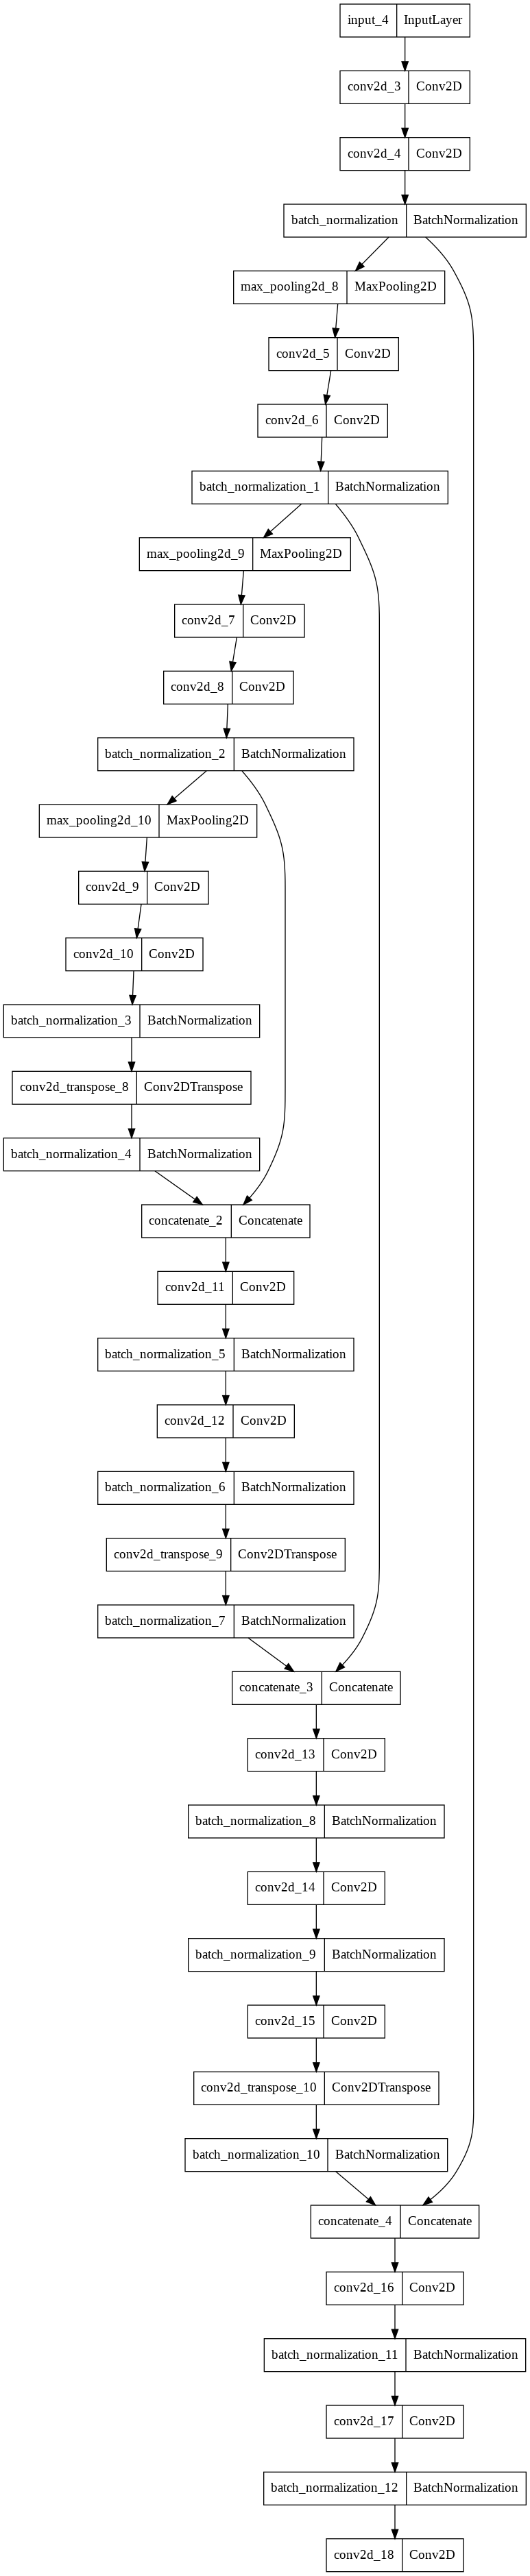

In [ ]:
plot_model(unet)

In [42]:
#unet.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy' )
unet.compile(loss='categorical_crossentropy', optimizer=Adam(lr=3e-4))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [43]:
import tensorflow as tf
#checkpoint_filepath = '/tmp/checkpoint'
checkpoint_filepath_unet = pathNameTrain + prefix + 'checkpoint_mAir_UNet'
model_checkpoint_callback_unet = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_unet,
    save_weights_only=True,
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True)

### Train Model

In [ ]:
history = unet.fit(x_train,y_train,
                   batch_size=8,
                   callbacks=[model_checkpoint_callback_unet, TqdmCallback()],
                   validation_data=(x_val,y_val),
                   epochs=20)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
113/113 [==============================] - 66s 511ms/step - loss: 0.3728 - val_loss: 1.5071
Epoch 2/20
113/113 [==============================] - 54s 481ms/step - loss: 0.2085 - val_loss: 0.8519
Epoch 3/20
113/113 [==============================] - 54s 480ms/step - loss: 0.1230 - val_loss: 0.1294
Epoch 4/20
113/113 [==============================] - 54s 481ms/step - loss: 0.0780 - val_loss: 0.1244
Epoch 5/20
113/113 [==============================] - 54s 481ms/step - loss: 0.0669 - val_loss: 0.0736
Epoch 6/20
113/113 [==============================] - 54s 481ms/step - loss: 0.0605 - val_loss: 0.0652
Epoch 7/20
113/113 [==============================] - 54s 481ms/step - loss: 0.0578 - val_loss: 0.0987
Epoch 8/20
113/113 [==============================] - 54s 481ms/step - loss: 0.0531 - val_loss: 0.0616
Epoch 9/20
113/113 [==============================] - 54s 481ms/step - loss: 0.0520 - val_loss: 0.0604
Epoch 10/20
113/113 [==============================] - 54s 481ms/step - l

In [ ]:

unet.save_weights(pathNameTrain + prefix + 'unet_20e_ohe.h5')

### Prediction

In [46]:
#unet.load_weights(pathNameTrain + prefix + 'unet_20e.h5')
unet.load_weights(pathNameTrain + prefix + 'unet_20e_ohe.h5')

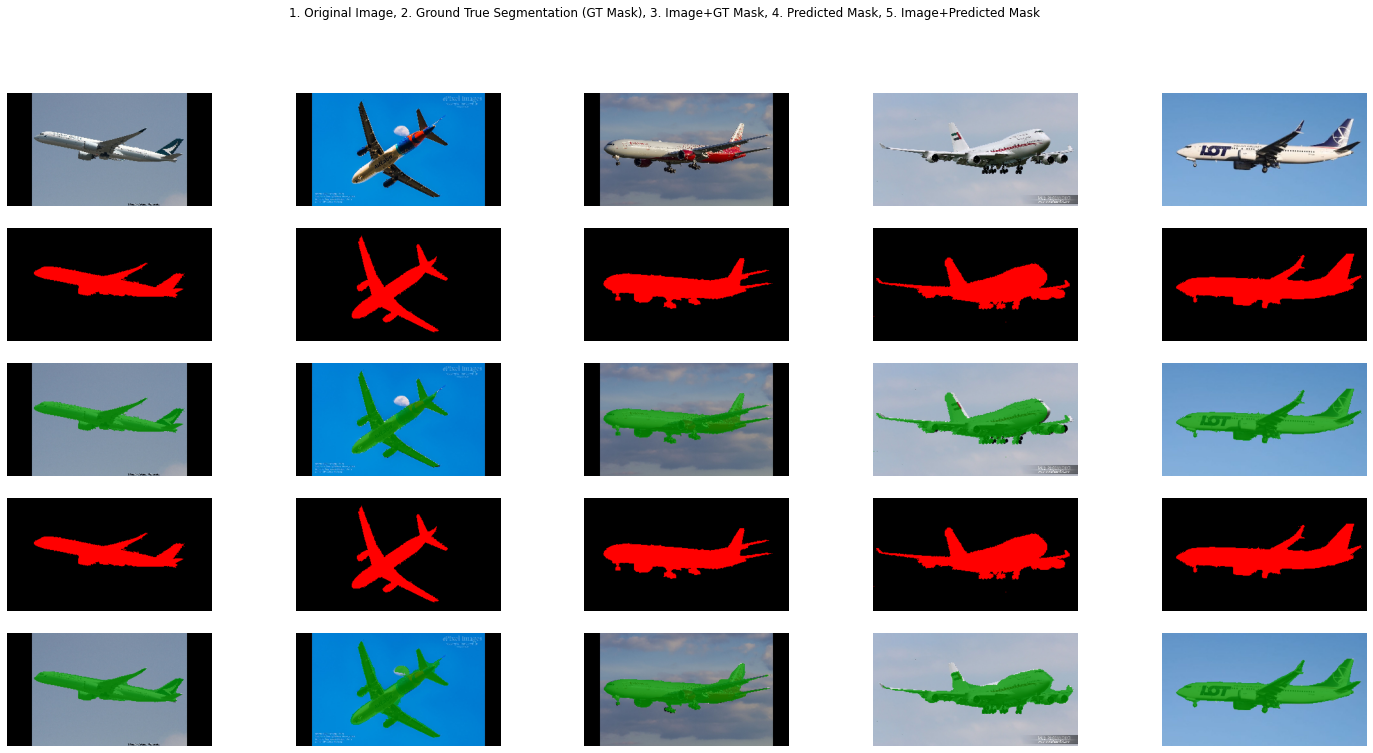

In [48]:
n_cols = 5
n_rows = 5
n_classes = 2
indexes = np.random.randint(0, len(x_val), n_cols) 
plot_original_predicted_images_masks(indexes, unet)

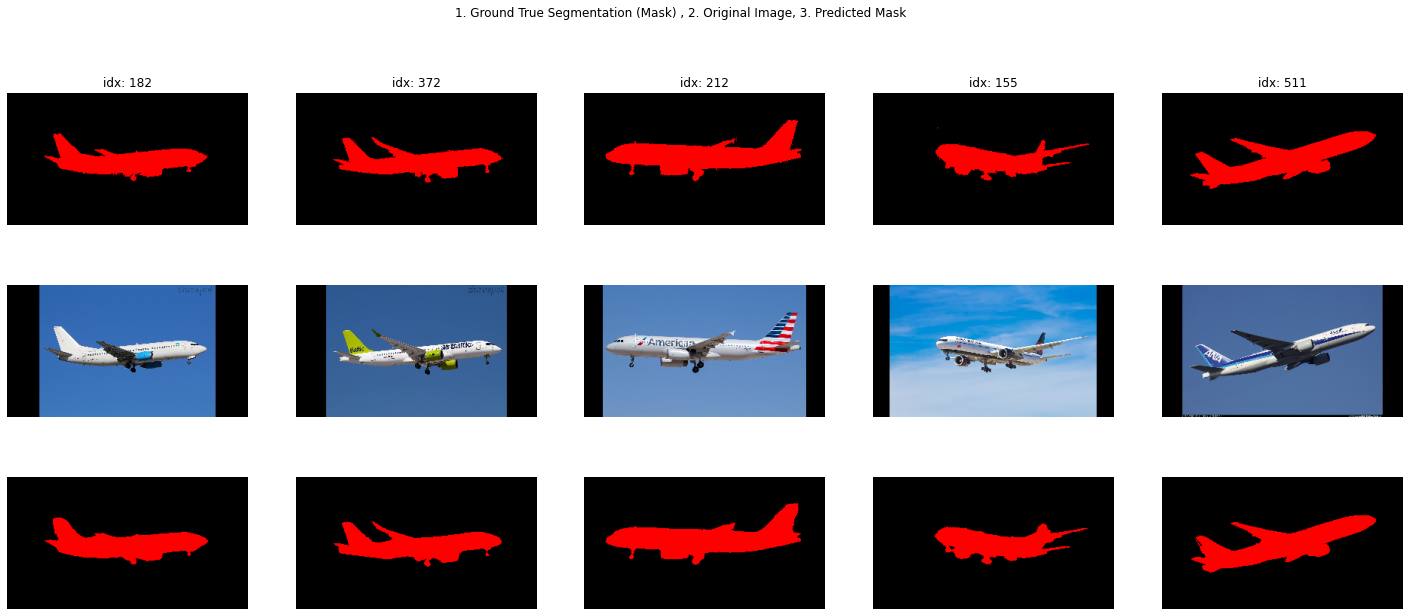

In [49]:
plot_gen_images(unet) 